In [3]:
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score


In [4]:
zip_file_path = 'credit_card_approval.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

csv_directory = os.getcwd()
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(csv_directory, filename)
        if 'df1' not in globals():
            df1 = pd.read_csv(file_path)
        else:
            df2 = pd.read_csv(file_path)

print(df1.head())
print(df2.head())

        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005 

Rimuovo i duplicati in df1

In [5]:
df1 = df1.drop_duplicates()

ID ricorrenti

In [6]:
id_counts = df1.groupby('ID').size()
multiple_occurrences = id_counts[id_counts > 1].index.tolist()
df1 = df1[~df1['ID'].isin(multiple_occurrences)]

Filtrare ID in df1 presenti in df2

In [7]:
df1 = df1[df1['ID'].isin(df2['ID'])]

Valori mancanti

In [8]:
df1 = df1.drop('OCCUPATION_TYPE', axis=1)
print(df1.describe())

                 ID  CNT_CHILDREN  AMT_INCOME_TOTAL    DAYS_BIRTH  \
count  3.645700e+04  36457.000000      3.645700e+04  36457.000000   
mean   5.078227e+06      0.430315      1.866857e+05 -15975.173382   
std    4.187524e+04      0.742367      1.017892e+05   4200.549944   
min    5.008804e+06      0.000000      2.700000e+04 -25152.000000   
25%    5.042028e+06      0.000000      1.215000e+05 -19438.000000   
50%    5.074614e+06      0.000000      1.575000e+05 -15563.000000   
75%    5.115396e+06      1.000000      2.250000e+05 -12462.000000   
max    5.150487e+06     19.000000      1.575000e+06  -7489.000000   

       DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE    FLAG_PHONE    FLAG_EMAIL  \
count   36457.000000     36457.0     36457.000000  36457.000000  36457.000000   
mean    59262.935568         1.0         0.225526      0.294813      0.089722   
std    137651.334859         0.0         0.417934      0.455965      0.285787   
min    -15713.000000         1.0         0.000000     

Rimuovo flag_mobil

In [9]:
df1 = df1.drop("FLAG_MOBIL", axis=1)

Range di età

In [10]:
min_age = abs(df1["DAYS_BIRTH"]).min() / 365
max_age = abs(df1["DAYS_BIRTH"]).max() / 365
print(f"The minimum and maximum ages are around: {round(min_age)}, {round(max_age)}")

The minimum and maximum ages are around: 21, 69


Controllo che i giorni lavorati siano inferiori ai giorni vissuti

In [11]:
def check_employment_variable_plausibility(days_employed, days_birth):
    days_birth = abs(days_birth)
    days_employed = abs(days_employed)
    boolean_mask = days_employed >= days_birth
    if sum(boolean_mask) > 0:
        print("errore: days_employed > days_birth")
    else:
        boolean_mask = None
    return boolean_mask

days_employed, days_birth = df1["DAYS_EMPLOYED"], df1["DAYS_BIRTH"]
boolean_mask = check_employment_variable_plausibility(days_employed, days_birth)
if boolean_mask is not None:
    df1 = df1[~boolean_mask]

errore: days_employed > days_birth


Filtrare ID in df2 presenti in df1

In [12]:
df2 = df2[df2['ID'].isin(df1['ID'])]

Mapping variabile status e check sui 12 mesi

In [13]:
status_mapping = {'0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, 'X': 0, 'C': 1}
df2["STATUS"] = df2["STATUS"].map(status_mapping)
threshold = 12
id_counts = df2.groupby('ID').size()
valid_ids = id_counts[id_counts >= threshold].index
df2 = df2[df2['ID'].isin(valid_ids)]

Rielaborazione df2 pre analisi

In [14]:
df2["MEAN_STATUS"] = df2.groupby('ID')["STATUS"].transform("mean")
df2["MAX_STATUS"] = df2.groupby('ID')["STATUS"].transform("max")
df2 = df2.drop(["MONTHS_BALANCE", "STATUS"], axis=1)
df2.drop_duplicates(subset='ID', inplace=True)


Classificazione in base ai valori Mean e Max 

In [15]:
df2.loc[(df2["MEAN_STATUS"] <= 1) & (df2["MAX_STATUS"] <= 2), "CLASS"] = 0
df2.loc[df2["MEAN_STATUS"] > 1, "CLASS"] = 1
df2.loc[df2["MAX_STATUS"] > 2, "CLASS"] = 1

Merge

In [16]:
df = pd.merge(df1, df2[["ID", "CLASS"]], on='ID', how='inner')

Train and test set

In [17]:
X = df.drop(["ID", "CLASS"], axis=1)
y = df["CLASS"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

education_mapping = {"Lower secondary": 1, "Secondary / secondary special": 2, "Incomplete higher": 3, "Higher education": 4, "Academic degree": 5}
X_train["NAME_EDUCATION_TYPE"] = X_train["NAME_EDUCATION_TYPE"].map(education_mapping)
X_test["NAME_EDUCATION_TYPE"] = X_test["NAME_EDUCATION_TYPE"].map(education_mapping)

gender_mapping = {"F": 1, "M": 0}
X_train["CODE_GENDER"] = X_train["CODE_GENDER"].map(gender_mapping)
X_test["CODE_GENDER"] = X_test["CODE_GENDER"].map(gender_mapping)

car_mapping = {"Y": 1, "N": 0}
X_train["FLAG_OWN_CAR"] = X_train["FLAG_OWN_CAR"].map(car_mapping)
X_test["FLAG_OWN_CAR"] = X_test["FLAG_OWN_CAR"].map(car_mapping)

realty_mapping = {"Y": 1, "N": 0}
X_train["FLAG_OWN_REALTY"] = X_train["FLAG_OWN_REALTY"].map(realty_mapping)
X_test["FLAG_OWN_REALTY"] = X_test["FLAG_OWN_REALTY"].map(realty_mapping)

One-hot encoding

In [18]:
encoder = ColumnTransformer(
    transformers=[
        ("encoder", OneHotEncoder(), ["NAME_INCOME_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"])
    ],
    remainder='passthrough'
)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

Scaling

In [19]:
ss = StandardScaler()
X_train_st = ss.fit_transform(X_train)
X_test_st = ss.transform(X_test)

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

Metriche

In [31]:
def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"]):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=labels, columns=["Predicted " + labels[0], "Predicted " + labels[1]])
    sns.heatmap(df_cm, annot=True, fmt='d')

def evaluate_model(y_test, y_pred_test, y_train, y_pred_train):
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
    specificity_train = tn / (tn + fp)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    specificity_test = tn / (tn + fp)
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    print(f"Recall TRAIN: {recall_train:.2f}, Recall TEST: {recall_test:.2f}")
    print(f"Specificity TRAIN: {specificity_train:.2f}, Specificity TEST: {specificity_test:.2f}")
    print(f"Accuracy TEST: {accuracy_score(y_test, y_pred_test):.2f}")
    print(f"Precision TEST: {precision_score(y_test, y_pred_test):.2f}")
    print(f"F1 Score TEST: {f1_score(y_test, y_pred_test):.2f}")
    print(f"ROC AUC TEST: {roc_auc_score(y_test, y_proba_test):.2f}")


Regressione Logistica

Recall TRAIN: 1.00, Recall TEST: 1.00
Specificity TRAIN: 0.00, Specificity TEST: 0.00
Accuracy TEST: 0.80
Precision TEST: 0.80
F1 Score TEST: 0.89
ROC AUC TEST: 0.54


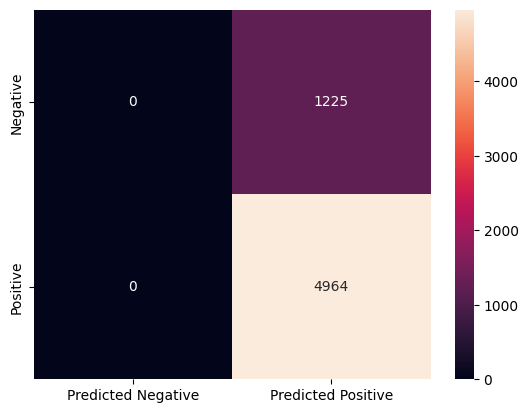

In [33]:
lr = LogisticRegression()
lr.fit(X_train_st, y_train)
y_pred_train = lr.predict(X_train_st)
y_proba_train = lr.predict_proba(X_train_st)
y_pred_test = lr.predict(X_test_st)
y_proba_test = lr.predict_proba(X_test_st)[:, 1]
plot_confusion_matrix(y_test, y_pred_test)
evaluate_model(y_test, y_pred_test, y_train, y_pred_train)

Il modello sta classificando correttamente tutti i positivi in entrambi i set di dati. Tuttavia, ottenere un recall di 1.00 è sospetto, soprattutto se non è accompagnato da buoni valori di specificità. Il modello non sta classificando correttamente nessuno dei negativi. In altre parole, sta classificando tutti gli esempi come positivi.

Curva ROC AUC

In [34]:
y_proba_test = lr.predict_proba(X_test_st)[:, 1]

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

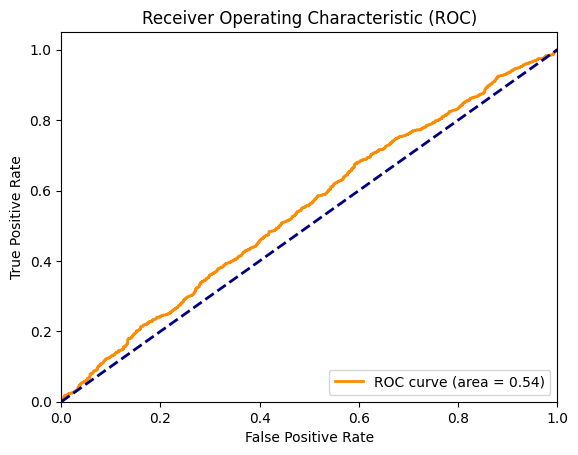

In [36]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [37]:
y_proba_test = lr.predict_proba(X_test_st)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)

f1_scores = 2 * (precision * recall) / (precision + recall)

best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

y_pred_best_threshold = (y_proba_test >= best_threshold).astype(int)

Recall TRAIN: 1.00, Recall TEST: 1.00
Specificity TRAIN: 0.00, Specificity TEST: 0.00
Accuracy TEST: 0.80
Precision TEST: 0.80
F1 Score TEST: 0.89
ROC AUC TEST: 0.54


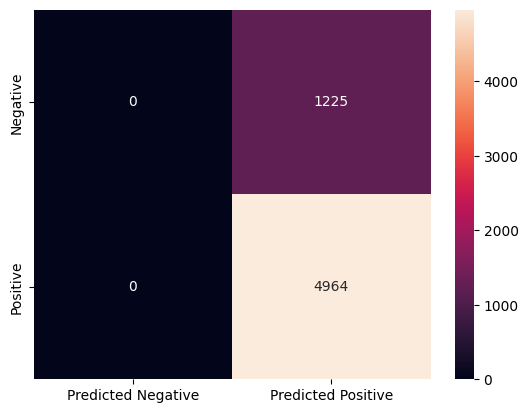

In [38]:
plot_confusion_matrix(y_test, y_pred_best_threshold)
evaluate_model(y_test, y_pred_best_threshold, y_train, y_pred_train)

KNN neighbors 5

Recall TRAIN: 0.95, Recall TEST: 0.92
Specificity TRAIN: 0.43, Specificity TEST: 0.27
Accuracy TEST: 0.79
Precision TEST: 0.84
F1 Score TEST: 0.88
ROC AUC TEST: 0.68


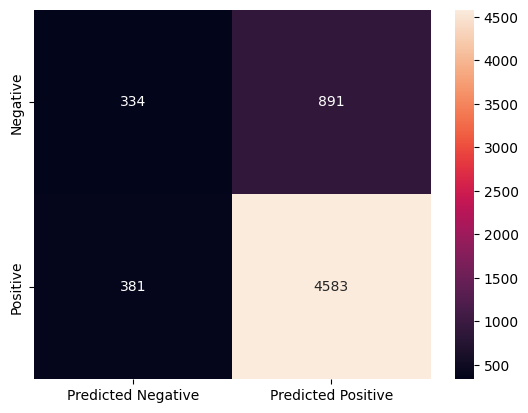

In [40]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_st, y_train)
y_pred_train = knn.predict(X_train_st)
y_proba_train = knn.predict_proba(X_train_st)
y_pred_test = knn.predict(X_test_st)
y_proba_test = knn.predict_proba(X_test_st)[:, 1]
plot_confusion_matrix(y_test, y_pred_test)
evaluate_model(y_test, y_pred_test, y_train, y_pred_train)

Questa matrice di confusione indica che:

- Classe Positiva: Il modello è in grado di riconoscere bene le istanze positive (con 4583 classificazioni corrette), ma c'è ancora un numero significativo di falsi negativi (381).
- Classe Negativa: La classe negativa è meno ben classificata, con solo 334 istanze correttamente identificate e un numero elevato di falsi positivi (891).

KNN neighbors 5 e soglia a 0.8

Recall TRAIN: 0.54, Recall TEST: 0.47
Specificity TRAIN: 0.98, Specificity TEST: 0.76
Accuracy TEST: 0.53
Precision TEST: 0.89
F1 Score TEST: 0.62
ROC AUC TEST: 0.68


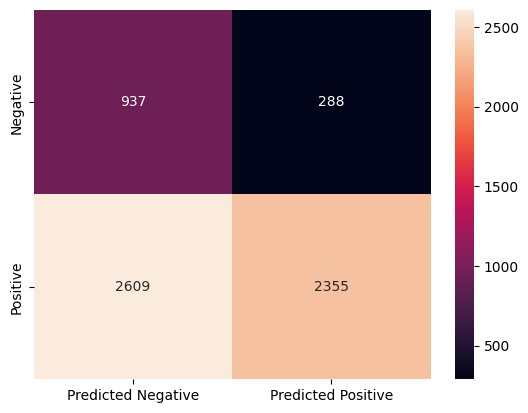

In [47]:
y_pred_train = np.where(y_proba_train[:, 1] > 0.8, 1, 0)
y_pred_test = np.where(y_proba_test > 0.8, 1, 0)
plot_confusion_matrix(y_test, y_pred_test)
evaluate_model(y_test, y_pred_test, y_train, y_pred_train)

Il modello mostra una buona capacità di identificare i positivi ma ha difficoltà a identificare correttamente i negativi

KNN Neighbors 3

Recall TRAIN: 0.94, Recall TEST: 0.90
Specificity TRAIN: 0.54, Specificity TEST: 0.33
Accuracy TEST: 0.79
Precision TEST: 0.85
F1 Score TEST: 0.87
ROC AUC TEST: 0.68


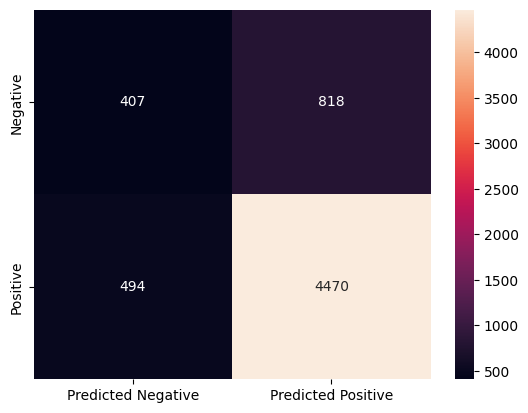

In [48]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_st, y_train)
y_pred_train = knn.predict(X_train_st)
y_proba_train = knn.predict_proba(X_train_st)
y_pred_test = knn.predict(X_test_st)
y_proba_test = knn.predict_proba(X_test_st)[:, 1]
plot_confusion_matrix(y_test, y_pred_test)
evaluate_model(y_test, y_pred_test, y_train, y_pred_train)

FP= 818 e FN= 494: Un numero elevato di falsi positivi significa che un numero significativo di persone non idonee potrebbe ottenere una carta di credito, il che è rischioso.

KNN Neighbors 2

Recall TRAIN: 0.81, Recall TEST: 0.73
Specificity TRAIN: 0.86, Specificity TEST: 0.59
Accuracy TEST: 0.71
Precision TEST: 0.88
F1 Score TEST: 0.80
ROC AUC TEST: 0.67


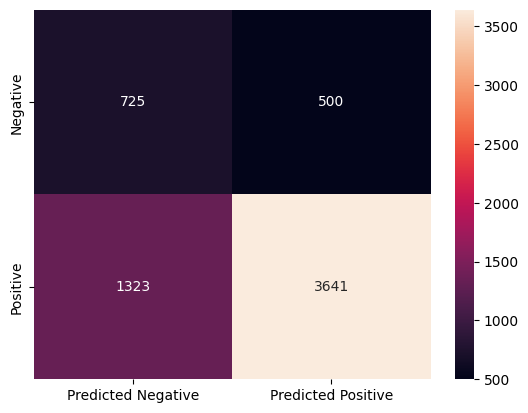

In [52]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_st, y_train)
y_pred_train = knn.predict(X_train_st)
y_proba_train = knn.predict_proba(X_train_st)
y_pred_test = knn.predict(X_test_st)
y_proba_test = knn.predict_proba(X_test_st)[:, 1]
plot_confusion_matrix(y_test, y_pred_test)
evaluate_model(y_test, y_pred_test, y_train, y_pred_train)

FP= 500 e FN= 1323: Sebbene il numero di falsi positivi sia ridotto, c'è un numero maggiore di falsi negativi, quindi più persone idonee non ottengono una carta di credito, rispetto neighbors = 3.

Scelgo il Modello KNN con neighbors = 2 poichè ritengo che sia preferibile minimizzare i falsi positivi, senza eccedere nei falsi negativi. Un numero elevato di FP può portare ad un problema finanziario non trascurabile per una banca.